In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [9]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error as MSE

# 数据集

In [10]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [11]:
boston.data.shape

(506, 13)

In [12]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [13]:
data = pd.DataFrame(boston.data, columns = boston.feature_names)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [14]:
X = data
y = boston.target

In [15]:
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y, test_size=0.3, random_state=29)

In [16]:
print(Xtrain.shape)
print(Xtest.shape)

(354, 13)
(152, 13)


-----

XGBoost的两种接口

# xgb接口

In [17]:
import xgboost as xgb

In [18]:
dtrain = xgb.DMatrix(Xtrain, ytrain)
dtest = xgb.DMatrix(Xtest,ytest)

In [19]:
xgb.__version__

'1.1.1'

注意上面xgb的版本，0.90版本的XGB是没有`'objective': 'reg:squaredlogerror'`这个参数的

## 配置参数  
下面的参数都是默认值，只不过显式写出来了

In [20]:
# 这个params字段里配置的是 Booster 类的参数
params = {'booster':'gbtree',  #基分类器
          'objective': 'reg:squarederror', #目标函数
#           'objective': 'reg:squaredlogerror',
         'eta': 0.3,  #学习速率
         'gamma': 0,  #分咧的最小增益
         'max_depth': 6,  #树的最大深度
         'lambda': 1,  #L2正则项系数
         'alpha': 0,  # L1正则项系数
         'subsample': 1,  #boostrap是的采样比例
         'tree': 'auto',  # 树的生成方式
         'base_score': 0.5,  # 生成第一棵树时的初始值
         'eval_metric': ['rmse','mae']}  # 在 验证集 上进行评估的指标，可以选择多个

# booster的个数
num_round = 10

# 用于训练时查看验证集上效果的 evals (list of pairs (DMatrix, string)) 
watch_list = [(dtrain, 'train'), (dtest, 'eval')]

## 训练模型  
`params`里设置的`eval_metric`参数会配合`watch_list`参数使用，会显示`num_round`行记录，每行有$eval\_metric*watch\_list$的记录 

In [21]:
bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_round
                , evals=watch_list
               )

[13:58:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:17.09619	train-mae:15.57532	eval-rmse:17.03543	eval-mae:15.47936
[1]	train-rmse:12.35078	train-mae:11.04634	eval-rmse:12.37152	eval-mae:10.96176
[2]	train-rmse:8.97849	train-mae:7.85870	eval-rmse:9.14436	eval-mae:7.82454
[3]	train-rmse:6.59204	train-mae:5.60841	eval-rmse:7.02082	eval-mae:5.72816
[4]	train-rmse:4.90564	train-mae:4.04055	eval-rmse:5.58317	eval-mae:4.32838
[5]	train-rmse:3.71914	train-mae:2.93160	eval-rmse:4.70710	eval-mae:3.47626
[6]	train-rmse:2.88353	train-mae:2.20503	eval-rmse:4.21405	eval-mae:3.03410
[7]	train-rmse:2.28600	train-mae:1.71135	eval-rmse:3.85263	eval-mae:2.74129
[8

## 绘制特征重要性  
`xgboost.plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', fmap='', importance_type='weight', max_num_features=None, grid=True, show_values=True, **kwargs)`  

 + importance_type (str, default "weight")
 How the importance is calculated: either “weight”, “gain”, or “cover”
   + ”weight” is the number of times a feature appears in a tree —— 特征在树中出现的次数
   + ”gain” is the average gain of splits which use the feature —— 使用该特征进行分割时的平均gain
   + ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

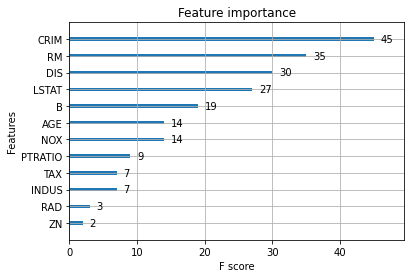

In [14]:
xgb.plot_importance(booster=bst, importance_type='weight')

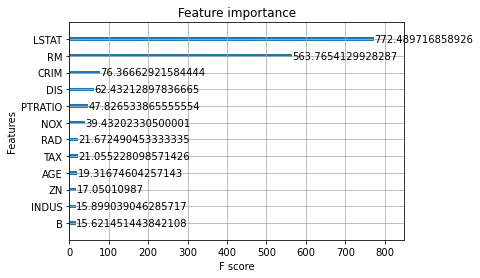

In [15]:
xgb.plot_importance(booster=bst, importance_type='gain')

+ 绘制树  
`xgboost.plot_tree(booster, fmap='', num_trees=0, rankdir=None, ax=None, **kwargs)`  
`xgboost.to_graphviz(booster, fmap='', num_trees=0, rankdir=None, yes_color=None, no_color=None, condition_node_params=None, leaf_node_params=None, **kwargs)`

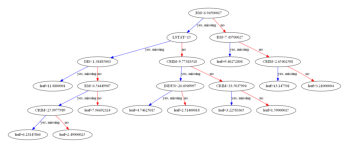

In [16]:
xgb.plot_tree(booster=bst, num_trees=0)

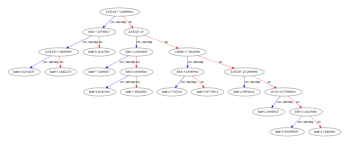

In [17]:
xgb.plot_tree(booster=bst, num_trees=1)

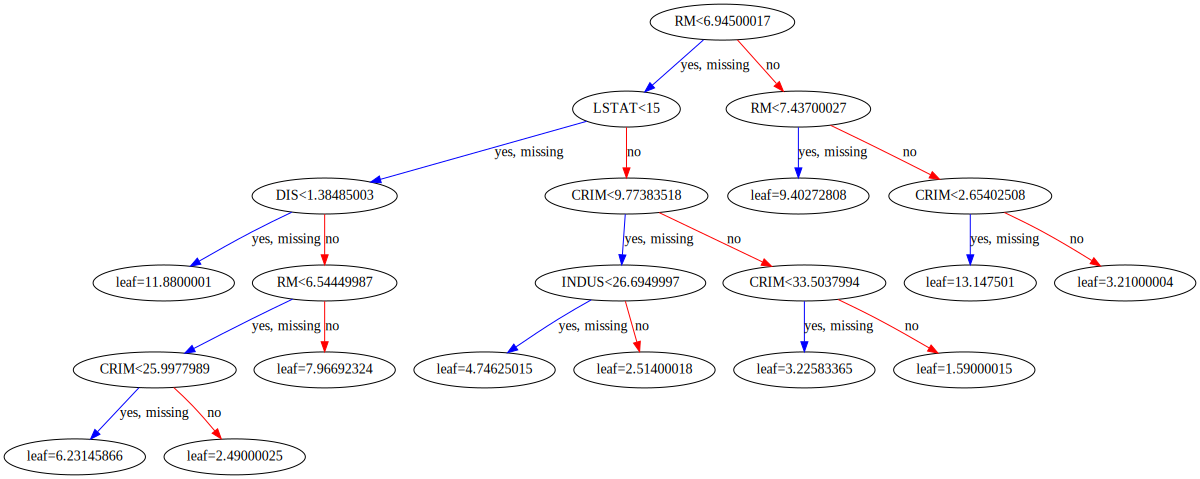

In [18]:
xgb.to_graphviz(booster=bst,num_trees=0)

## 查看训练之后的模型的各个参数

In [19]:
bst.attributes()

{}

In [20]:
bst.get_fscore()

{'RM': 35,
 'LSTAT': 27,
 'DIS': 30,
 'CRIM': 45,
 'INDUS': 7,
 'NOX': 14,
 'RAD': 3,
 'AGE': 14,
 'PTRATIO': 9,
 'B': 19,
 'ZN': 2,
 'TAX': 7}

In [21]:
bst.get_score(importance_type='weight')

{'RM': 35,
 'LSTAT': 27,
 'DIS': 30,
 'CRIM': 45,
 'INDUS': 7,
 'NOX': 14,
 'RAD': 3,
 'AGE': 14,
 'PTRATIO': 9,
 'B': 19,
 'ZN': 2,
 'TAX': 7}

In [22]:
bst.get_score(importance_type='gain')

{'RM': 563.7654129928287,
 'LSTAT': 772.489716858926,
 'DIS': 62.43212897836665,
 'CRIM': 76.36662921584444,
 'INDUS': 15.899039046285717,
 'NOX': 39.43202330500001,
 'RAD': 21.672490453333335,
 'AGE': 19.31674604257143,
 'PTRATIO': 47.826533865555554,
 'B': 15.621451443842108,
 'ZN': 17.05010987,
 'TAX': 21.055228098571426}

## 预测结果

In [23]:
ytrain_predict = bst.predict(dtrain)
ytest_predict = bst.predict(dtest)
print(ytrain_predict.shape)
print(ytest_predict.shape)

(354,)
(152,)


In [24]:
# 下面这结果应该和上面模型训练时输出的最后一个结果一致
print(  MSE(ytrain, ytrain_predict)**(1/2)   )
print(  MSE(ytest, ytest_predict)**(1/2)  )

1.606395814779231
3.550040035845486


## 交叉验证  
`xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)`

In [90]:
# 这个params字段里配置的是 Booster 类的参数
params = {'booster':'gbtree',  #基分类器
          'objective': 'reg:squarederror', #目标函数
         'eta': 0.3,  #学习速率
         'gamma': 0,  #分咧的最小增益
         'max_depth': 6,  #树的最大深度
         'lambda': 1,  #L2正则项系数
         'alpha': 0,  # L1正则项系数
         'subsample': 1,  #boostrap是的采样比例
         'tree': 'auto',  # 树的生成方式
         'base_score': 0.5,  # 生成第一棵树时的初始值
         'eval_metric': ['rmse']}  # 在 验证集 上进行评估的指标，可以选择多个

# booster的个数
num_round = 10

# 交叉验证的折数
n_fold = 5

In [91]:
history = xgb.cv(params=params, dtrain=dtrain, num_boost_round=num_round, nfold=n_fold)

XGB里的CV函数（默认）返回的是一个DF，行数=树的个数`num_boost_round`，列数=`eval_metric`的长度*2，第一个在nfold上的误差均值，第二个是标准差

In [92]:
history

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.153311,0.071318,17.266638,0.451084
1,12.423677,0.061084,12.698785,0.441580
2,9.071639,0.034572,9.469164,0.411159
3,6.712857,0.030572,7.393498,0.363906
4,5.013966,0.025305,5.953139,0.340723
5,3.822156,0.043644,5.159066,0.370705
6,2.967681,0.041042,4.591993,0.382552
7,2.365122,0.041977,4.252029,0.393327
8,1.923012,0.044468,4.072341,0.445608
9,1.609181,0.071512,3.959653,0.461702


+ 使用交叉验证来寻找最优的超参数`num_boost_round`  
这个不太一样，因为XGB的CV会返回每一轮的树的CV结果，所以只需要把`num_boost_round`  设置的足够大，然后在结果里找mean里较小的，或者误差下降不太明显处的`num_boost_round`  就可以了。

In [93]:
# 取150个
history = xgb.cv(params=params, dtrain=dtrain, num_boost_round=150, nfold=n_fold)

In [94]:
history.shape

(150, 4)

In [114]:
# 这里使用plotly绘图，绘图前需要将history从wide格式转成long格式

# 增加一列表示 num_round
history['num_round'] = np.arange(1,151)

#分别提取训练误差和测试误差
train_info = history.loc[:,['num_round','train-rmse-mean','train-rmse-std']]
test_info = history.loc[:,['num_round','test-rmse-mean','test-rmse-std']]

# 需要改名，否则会产生多余的null列
train_info.columns = ['num_round','rmse-mean','rmse-std']
test_info.columns = ['num_round','rmse-mean','rmse-std']

# 增加一列用户区分训练误差和测试误差
train_info['type'] = 'train'
test_info['type'] = 'test'

# 合并
history_info = pd.concat([train_info, test_info], axis=0)

In [115]:
history.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,num_round
0,17.153311,0.071318,17.266638,0.451084,1
1,12.423677,0.061084,12.698785,0.441580,2
2,9.071639,0.034572,9.469164,0.411159,3
3,6.712857,0.030572,7.393498,0.363906,4
4,5.013966,0.025305,5.953139,0.340723,5


In [116]:
history_info.head()

,num_round,rmse-mean,rmse-std,type
0,1,17.153311,0.071318,train
1,2,12.423677,0.061084,train
2,3,9.071639,0.034572,train
3,4,6.712857,0.030572,train
4,5,5.013966,0.025305,train


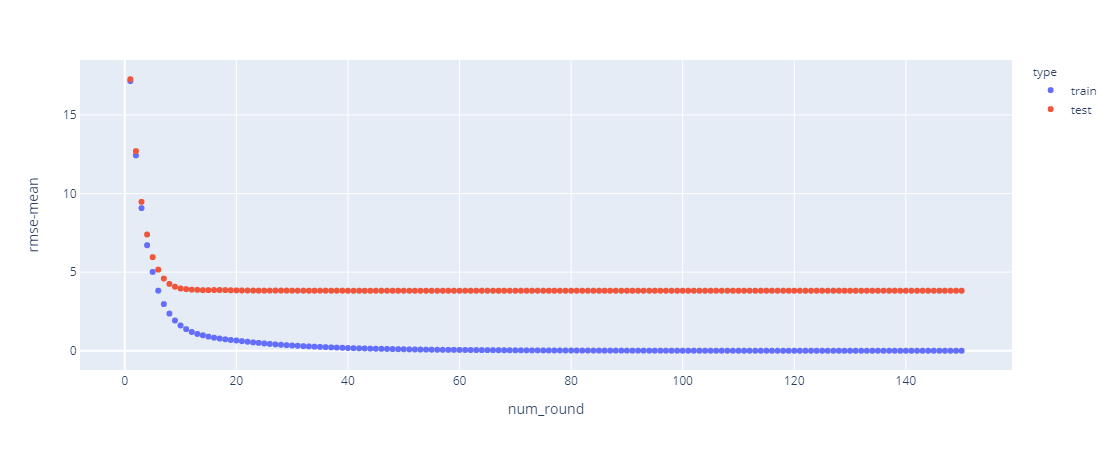

In [118]:
# 使用plotly绘制
px.scatter(data_frame=history_info, x='num_round',y='rmse-mean', color='type' )

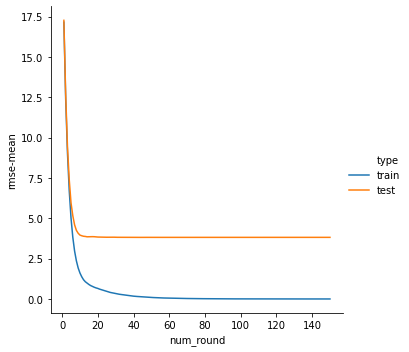

In [119]:
# 使用seaborn绘制
sns.relplot(data=history_info, x ='num_round', y='rmse-mean', hue='type', kind='line' )

从图中可以看出 num_round = 15 之后test-rmse就不太下降了，所以只需要选择 num_round = 15 即可

____________

# Sklearn接口

In [42]:
# xgboost库里的参数配置
# 这个params字段里配置的是 Booster 类的参数
params = {'booster':'gbtree',  #基分类器
          'objective': 'reg:squarederror', #目标函数
         'eta': 0.3,  #学习速率
         'gamma': 0,  #分咧的最小增益
         'max_depth': 6,  #树的最大深度
         'lambda': 1,  #L2正则项系数
         'alpha': 0,  # L1正则项系数
         'subsample': 1,  #boostrap是的采样比例
         'tree': 'auto',  # 树的生成方式
         'base_score': 0.5,  # 生成第一棵树时的初始值
         'eval_metric': ['rmse','mae']}  # 在 验证集 上进行评估的指标，可以选择多个

# booster的个数
num_round = 10

# 用于训练时查看验证集上效果的 evals (list of pairs (DMatrix, string)) 
watch_list = [(dtrain, 'train'), (dtest, 'eval')]

In [57]:
from xgboost import XGBRegressor as XGBR

In [58]:
# sklearn接口不能使用字典的形式配置参数
xgbr = XGBR(
    booster = 'gbtree',
    objective='reg:squarederror',
    n_estimators = 10, #相当于num_booster_round
    max_depth = 6,
    learning_rate = 0.3, # 学习速率
    tree_method = 'auto',
    gammar = 0,
    reg_alpah= 0, # L1正则化参数
    reg_lambda= 1, # L2正则化参数
    subsample= 1,
    base_score= 0.5
)

In [59]:
xgbr.fit(X=Xtrain,y=ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gammar=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpah=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             tree_method='auto', verbosity=1)

In [73]:
# 也可以传入验证集
xgbr.fit(X=Xtrain,y=ytrain, eval_set=[(Xtest, ytest)], eval_metric=['mae','rmse'])

[0]	validation_0-mae:15.4794	validation_0-rmse:17.0354
[1]	validation_0-mae:10.9618	validation_0-rmse:12.3715
[2]	validation_0-mae:7.82454	validation_0-rmse:9.14436
[3]	validation_0-mae:5.72816	validation_0-rmse:7.02082
[4]	validation_0-mae:4.32838	validation_0-rmse:5.58317
[5]	validation_0-mae:3.47626	validation_0-rmse:4.7071
[6]	validation_0-mae:3.0341	validation_0-rmse:4.21405
[7]	validation_0-mae:2.74129	validation_0-rmse:3.85263
[8]	validation_0-mae:2.5822	validation_0-rmse:3.65708
[9]	validation_0-mae:2.48576	validation_0-rmse:3.55004


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gammar=0,
             importance_type='gain', learning_rate=0.3, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpah=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             tree_method='auto', verbosity=1)

In [74]:
xgbr.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 10,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1,
 'tree_method': 'auto',
 'gammar': 0,
 'reg_alpah': 0}

In [75]:
xgbr.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 10,
 'nthread': 1,
 'objective': 'reg:squarederror',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 1,
 'verbosity': 1,
 'tree_method': 'auto',
 'gammar': 0,
 'reg_alpah': 0}

In [76]:
xgbr.get_booster()

In [77]:
xgbr.get_num_boosting_rounds()

10

In [78]:
xgbr.feature_importances_

array([0.0456485 , 0.01019178, 0.00950372, 0.        , 0.02357067,
       0.33699337, 0.01154667, 0.03731909, 0.01295483, 0.01258586,
       0.02858853, 0.00933779, 0.46175924], dtype=float32)

In [79]:
# 这里默认返回的是R^2，不是MSE，可使用shift + tab查看签名
xgbr.score(Xtest,ytest)

0.841814503167488

In [83]:
y_predict = xgbr.predict(Xtest)

In [84]:
from sklearn.metrics import r2_score

In [85]:
r2_score(y_true=ytest, y_pred=ytest_predict)

0.8418145028374874

交叉验证效果

In [80]:
xgbr = XGBR(n_estimators=100)
cross_val_score(xgbr,X,y,cv=5)

[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.77955736, 0.85656904, 0.79106707, 0.57326677, 0.41285553])

In [81]:
# 查看sklearn中已有的指标
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [82]:
# 使用其他指标
cross_val_score(xgbr,X,y,cv=5,scoring='neg_mean_squared_error')

[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:59:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([ -7.61302966, -13.05748854, -16.73285435, -37.42956222,
       -15.6111833 ])

_________

In [89]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

In [101]:
# 线性回归
lr = LinearRegression()
lr.fit(Xtrain,ytrain)
lr.score(Xtest,ytest)

0.7769540740816125

In [102]:
# 随机森林
rf = RFR(n_estimators=20)
rf.fit(Xtrain,ytrain)
rf.score(Xtest,ytest)

0.8398599894467208

In [103]:
# XGBoost
xgbr = XGBR(
    booster = 'gbtree',
    objective='reg:squarederror',
    n_estimators = 10, #相当于num_booster_round
    max_depth = 6,
    learning_rate = 0.3, # 学习速率
    tree_method = 'auto',
    gammar = 0,
    reg_alpah= 0, # L1正则化参数
    reg_lambda= 1, # L2正则化参数
    subsample= 1,
    base_score= 0.5
)
xgbr.fit(X=Xtrain,y=ytrain)
xgbr.score(Xtest, ytest)

0.841814503167488

In [107]:
- cross_val_score(lr, X, y, cv=5, scoring='neg_mean_squared_error')

array([12.46030057, 26.04862111, 33.07413798, 80.76237112, 33.31360656])

In [106]:
- cross_val_score(rf,X,y,cv=5, scoring='neg_mean_squared_error')

array([ 8.01978039, 15.5468948 , 18.35381386, 43.13013738, 18.37307847])

In [108]:
- cross_val_score(xgbr,X,y,cv=5, scoring='neg_mean_squared_error')

array([ 8.5341622 , 16.5285442 , 20.92416823, 46.39984535, 17.47468213])

-------------

# XGBoost的调参

优先调整的参数  
+ `n_estimator`或者`num_boost_round`，一般在300以下
+ `gammar`，进行分支时的最小增益
+ `max_depth`，这个参数和上面的`gammar`通常选择一个进行调整就可以了
+ `colsample_bytree`，默认为1，列采样（每次生成树时随机抽样特征）的比例
+ `colsample_bylevel`，默认为1，每次生成**树的一层**时 随机抽样特征的比例
+ `colsample_bynode`，默认为1，每次生成**一个叶子节点**时 随机抽样特征的比例

通常不调整的参数  
+ 学习速率`eta`或者`learning_rate`，这个参数对于模型的收敛速度影响较大，但是通常**不调整这个**，即使调整，它的值也在$[0.01, 0.2]$之间变动
+ 采样比例`subsample`，默认为1，通常也不调整，只有在样本数据量非常大的时候才进行调整
+ 正则化参数 L1的`alpha`或者`reg_alpha`，L2的`lambda`或者`reg_lambda`，如果要调整，通常优先选择调整L2正则参数

观察n_estimator的学习曲线

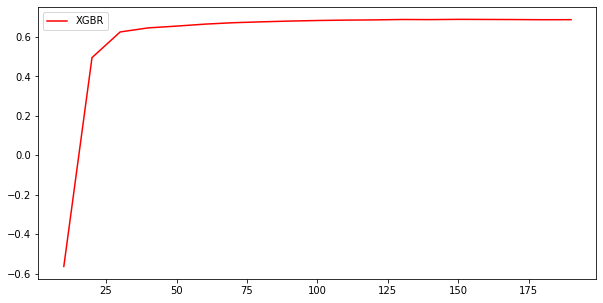

In [89]:
n_estimator_range = range(10, 200, 10)
score = []
for n_estimator in n_estimator_range:
    xgbr = XGBR(n_estimators=n_estimator, silent=True)
    result = cross_val_score(xgbr, X, y, cv=5).mean()
    score.append(result)
    
plt.figure(figsize=(10,5))
plt.plot(n_estimator_range, score, c='red', label='XGBR')
plt.legend()

In [90]:
print(n_estimator_range[score.index(max(score))], max(score))

150 0.6885265739694534


重新绘制带方差和偏差的学习曲线

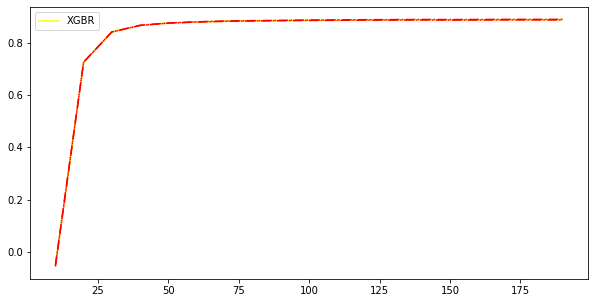

In [91]:
n_estimator_range = range(10, 200, 10)
cv = KFold(n_splits=5, shuffle=True, random_state=29)
score = []
var = []
ge = []

for n_estimator in n_estimator_range:
    xgbr = XGBR(n_estimators=n_estimator, silent=True)
    cv_result = cross_val_score(xgbr, X, y, cv=cv)
    score.append(cv_result.mean())
    var.append(cv_result.var())
    ge.append((1 - cv_result.mean())**2 + cv_result.var())

score = np.array(score)
var = np.array(var)

plt.figure(figsize=(10,5))
plt.plot(n_estimator_range, score, c='yellow', label='XGBR')
# 添加方差线
plt.plot(n_estimator_range, score-var, c='red', linestyle='-.')
plt.plot(n_estimator_range, score+var, c='red', linestyle='-.')
plt.legend()

调整增益参数$\gamma$
需要使用xgboost本身库里的xgboost.cv来查看效果

In [92]:
import xgboost as XGB

from time import time
from datetime import datetime

首先练习使用xgboost.cv()函数

In [93]:
data = XGB.DMatrix(X,y)
param = {'silent':True, 'obj':'reg:linear', 'gamma':0}
num_round = 180
n_fold = 5

In [94]:
time0 = time()
cv_result = XGB.cv(params=param, dtrain=data, num_boost_round=num_round, nfold=n_fold)
time_diff = time() - time0
print("running time : " + datetime.fromtimestamp(time_diff).strftime('%M:%S:%f'))

running time : 00:00:679215


In [95]:
type(cv_result)

pandas.core.frame.DataFrame

In [96]:
cv_result.__class__

pandas.core.frame.DataFrame

In [97]:
cv_result

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,17.105577,0.129117,17.163215,0.584297
1,12.337972,0.097556,12.519736,0.473458
2,8.994071,0.065756,9.404534,0.472310
3,6.629480,0.050323,7.250335,0.500342
4,4.954407,0.033209,5.920812,0.591874
...,...,...,...,...
175,0.001299,0.000289,3.669898,0.857676
176,0.001285,0.000261,3.669897,0.857677
177,0.001275,0.000239,3.669903,0.857669
178,0.001263,0.000217,3.669901,0.857672


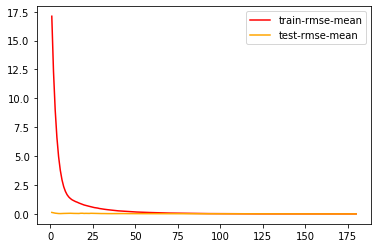

In [98]:
plt.plot(range(1, 181), cv_result.iloc[:,0], c='red', label="train-rmse-mean")
plt.plot(range(1,181), cv_result.iloc[:,1], c='orange', label='test-rmse-mean')
plt.legend()

使用xgboost.cv来调整$\gamma$

In [99]:
num_round = 180
n_fold = 5
param1 = {'silent':True, 'obj':'reg:linear', 'gamma':0}
param2 = {'silent':True, 'obj':'reg:linear', 'gamma':20}

cv_result1 = XGB.cv(params=param1, dtrain=data, num_boost_round=num_round, nfold=n_fold)
cv_result2 = XGB.cv(params=param2, dtrain=data, num_boost_round=num_round, nfold=n_fold)

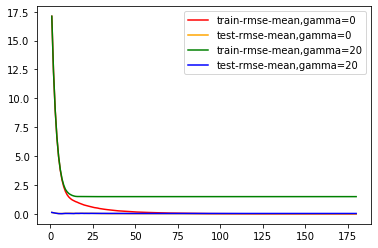

In [100]:
plt.plot(range(1, 181),cv_result1.iloc[:,0], c='red', label="train-rmse-mean,gamma=0")
plt.plot(range(1,181), cv_result1.iloc[:,1], c='orange', label='test-rmse-mean,gamma=0')
plt.plot(range(1,181), cv_result2.iloc[:,0], c='green', label="train-rmse-mean,gamma=20")
plt.plot(range(1,181), cv_result2.iloc[:,1], c='blue', label='test-rmse-mean,gamma=20')
plt.legend()

______

# 样本不均衡问题

------

# 对比随机森林和线性回归